<center><h1>DSCI 552: Machine Learning for Data Science</h1></center><br>

<h3>Final Project</h3>
<p></p>
<b><span>Name: Sri Manvith Vaddeboyina</span></b><br>
<b><span>USC ID: 1231409457</span></b><br>
<b><span>Github username: srimanvithv</span></b>

<b>1. Identification of Frost in Martian HiRISE Images</b>

<b>(a) In this problem, we are trying to build a classifier that distinguishes images of
Martian terrain with frost. You can find the dataset in
https://dataverse.jpl.nasa.gov/dataset.xhtml?persistentId=doi:10.48577/jpl.QJ9PYA
.
This dataset was created to study Mars’ seasonal frost cycle and its role in the
planet’s climate and surface evolution over the past 2 billion years. The data helps
in identifying low-latitude frosted microclimates and their impact on climate.</b>

In [1]:
import os
import json
import shutil
import logging
import numpy as np
import os.path as op
from tqdm import tqdm
from skimage import io
from pathlib import Path
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import precision_score, recall_score, f1_score
from tensorflow.keras import Sequential, layers, regularizers, optimizers
from tensorflow.keras.applications import EfficientNetB0, ResNet50, VGG16
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization

<b>(b) Data Exploration and Pre-processing</b>

<b>i. Images (png files) and labels (json files) are organized in the data directory
by “subframes.” Subframes are individual 5120x5120 pixel images which are
crops of the original HiRISE images (often on the order of 50k x 10k pixels).
Individual subframes were annotated by the contributors and then sliced into
299x299 “tiles.” Each tile has an associated label for use in training ML
algorithms.<br><br>
There are 214 subframes and a total of 119920 tiles. Each tile has annotations
which have been used to assign labels to the tiles ‘frost’ or ‘background.’
Each JSON file contains all the annotation information collected from human
annotators.<br><br>
The following are relevant to the assignment:
Image tiles are organized into folders of ‘background’ and ‘frost’ classes (bi-
nary). For the purpose of the final project, individual tiles shall serve as the
data points which need to be classified using binary classification.</b>

In [2]:
# Logging configuration
logging.basicConfig(level=logging.INFO,
                    datefmt='%H:%M:%S',
                    format='%(asctime)s | %(levelname)-5s | %(module)-15s | %(message)s')

IMAGE_SIZE = (299, 299)  # All images contained in this dataset are 299x299 (originally, to match Inception v3 input size)
SEED = 17

# Head directory containing all image subframes. Update with the relative path of your data directory
data_head_dir = Path('/content/data')

# Find all subframe directories
subdirs = [Path(subdir.stem) for subdir in data_head_dir.iterdir() if subdir.is_dir()]
src_image_ids = ['_'.join(a_path.name.split('_')[:3]) for a_path in subdirs]

In [3]:
# Load train/val/test subframe IDs
def load_text_ids(file_path):
    """Simple helper to load all lines from a text file"""
    with open(file_path, 'r') as f:
        lines = [line.strip() for line in f.readlines()]
    return lines

# Load the subframe names for the three data subsets
train_ids = load_text_ids('/content/drive/MyDrive/train_source_images.txt')
validate_ids = load_text_ids('/content/drive/MyDrive/val_source_images.txt')
test_ids = load_text_ids('/content/drive/MyDrive/test_source_images.txt')

# Generate a list containing the dataset split for the matching subdirectory names
subdir_splits = []
for src_id in src_image_ids:
    if src_id in train_ids:
        subdir_splits.append('train')
    elif src_id in validate_ids:
        subdir_splits.append('validate')
    elif(src_id in test_ids):
        subdir_splits.append('test')
    else:
        logging.warning(f'{src_id}: Did not find designated split in train/validate/test list.')
        subdir_splits.append(None)

In [4]:
import random
import tensorflow as tf
from PIL import Image

def load_and_preprocess(img_loc, label):

    def _inner_function(img_loc, label):

        # Convert tensor to native type
        img_loc_str = img_loc.numpy().decode('utf-8')
        label_str = label.numpy().decode('utf-8')

        img = Image.open(img_loc_str).convert('RGB')


        return img, 1 if label_str=='frost' else 0

    # Wrap the Python function
    X, y = tf.py_function(_inner_function, [img_loc, label], [tf.float32, tf.int64])

    return X, y

def load_subdir_data(dir_path, image_size, seed=None):

    """Helper to create a TF dataset from each image subdirectory"""

    # Grab only the classes that (1) we want to keep and (2) exist in this directory
    tile_dir = dir_path / Path('tiles')
    label_dir = dir_path /Path('labels')

    loc_list = []

    for folder in os.listdir(tile_dir):
        if os.path.isdir(os.path.join(tile_dir, folder)):
            for file in os.listdir(os.path.join(tile_dir, folder)):
                if file.endswith(".png"):
                    loc_list.append((os.path.join(os.path.join(tile_dir, folder), file), folder))

    return loc_list

# Loop over all subframes, loading each into a list
tf_data_train, tf_data_test, tf_data_val = [], [], []
tf_dataset_train, tf_dataset_test, tf_dataset_val = [], [], []

# Update the batch and buffer size as per your model requirements
buffer_size = 64
batch_size = 32

for subdir, split in zip(subdirs, subdir_splits):
    full_path = data_head_dir / subdir
    if split=='validate':
        tf_data_val.extend(load_subdir_data(full_path, IMAGE_SIZE, SEED))
    elif split=='train':
        tf_data_train.extend(load_subdir_data(full_path, IMAGE_SIZE, SEED))
    elif split=='test':
        tf_data_test.extend(load_subdir_data(full_path, IMAGE_SIZE, SEED))

random.shuffle(tf_data_train)
img_list, label_list = zip(*tf_data_train)
img_list_t = tf.convert_to_tensor(img_list)
lb_list_t = tf.convert_to_tensor(label_list)

tf_dataset_train = tf.data.Dataset.from_tensor_slices((img_list_t, lb_list_t))
tf_dataset_train = tf_dataset_train.map(load_and_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_train = tf_dataset_train.shuffle(buffer_size=buffer_size).batch(batch_size)

random.shuffle(tf_data_val)
img_list, label_list = zip(*tf_data_val)
img_list_t = tf.convert_to_tensor(img_list)
lb_list_t = tf.convert_to_tensor(label_list)

tf_dataset_val = tf.data.Dataset.from_tensor_slices((img_list_t, lb_list_t))
tf_dataset_val = tf_dataset_val.map(load_and_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_val = tf_dataset_val.shuffle(buffer_size=buffer_size).batch(batch_size)

random.shuffle(tf_data_test)
img_list, label_list = zip(*tf_data_train)
img_list_t = tf.convert_to_tensor(img_list)
lb_list_t = tf.convert_to_tensor(label_list)

tf_dataset_test = tf.data.Dataset.from_tensor_slices((img_list_t, lb_list_t))
tf_dataset_test = tf_dataset_test.map(load_and_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_test = tf_dataset_test.shuffle(buffer_size=buffer_size).batch(batch_size)

# 

<b>(c) Training CNN + MLP</b>

<b>i.
To perform empirical regularization, crop, randomly zoom, rotate, flip, con-
trast, and translate images in your training set for image augmentation. You
can use various tools to do this, including OpenCV.</b>

In [5]:
def one_hot_encode(image, label):
    label = tf.one_hot(label, depth=2)
    return image, label

def set_shapes(image, label):
    image.set_shape((None, 299, 299, 3))
    label.set_shape([None,2])
    return image, label

def apply_augmentation(image, label):
    return data_augmentation(image, training=True), label

In [6]:
datasets = [tf_dataset_train, tf_dataset_val, tf_dataset_test]

for dataset in datasets:
    dataset = dataset.map(one_hot_encode, num_parallel_calls=tf.data.experimental.AUTOTUNE)

augmentation_layers = [
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomZoom(0.2),
    layers.experimental.preprocessing.RandomContrast(0.2),
    layers.experimental.preprocessing.RandomTranslation(0.2, 0.2),
]

data_augmentation = tf.keras.Sequential(augmentation_layers)

tf_dataset_train_augmented = tf_dataset_train.map(set_shapes, num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_val_reshaped = tf_dataset_val.map(set_shapes, num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_test_reshaped = tf_dataset_test.map(set_shapes, num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_train_aug = tf_dataset_train_augmented.map(apply_augmentation, num_parallel_calls=tf.data.experimental.AUTOTUNE)

<b>ii. Train a three-layer CNN followed by a dense layer on the data. Choose the
size of the kernels and depth of the layers and the number of neurons in
the dense layer (MLP) on your own. Use ReLU’s in all of the layers. Use
the softmax function, batch normalization
3
and a dropout rate of 30%, L2
regularization, as well as ADAM optimizer. Use cross entropy loss. Train
for at least 20 epochs and perform early stopping using the validation set.
Keep the network parameters that have the lowest validation error. Plot the
training and validation errors vs. epochs.</b>

In [2]:
height = 299
width = 299
channels = 3

model = Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(height, width, channels)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dropout(0.3),
    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(2, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 297, 297, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 297, 297, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 148, 148, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 146, 146, 64)      18496     
                                                                 
 batch_normalization_1 (Bat  (None, 146, 146, 64)      256       
 chNormalization)                                                
                                                        

Epoch 1/25
928/928 [==============================] - 1061s 1s/step - loss: 2.8305 - accuracy: 0.6803 - val_loss: 2.3187 - val_accuracy: 0.2725
Epoch 2/25
928/928 [==============================] - 1152s 1s/step - loss: 1.1483 - accuracy: 0.7438 - val_loss: 4.0832 - val_accuracy: 0.7002
Epoch 3/25
928/928 [==============================] - 1063s 1s/step - loss: 1.1867 - accuracy: 0.7669 - val_loss: 1.7092 - val_accuracy: 0.5838
Epoch 4/25
928/928 [==============================] - 978s 1s/step - loss: 1.2616 - accuracy: 0.7571 - val_loss: 0.9489 - val_accuracy: 0.8262
Epoch 5/25
928/928 [==============================] - 984s 1s/step - loss: 0.9590 - accuracy: 0.7963 - val_loss: 2.5116 - val_accuracy: 0.4554
Epoch 6/25
928/928 [==============================] - 971s 1s/step - loss: 0.8004 - accuracy: 0.8171 - val_loss: 1.2824 - val_accuracy: 0.5794
Epoch 7/25
928/928 [==============================] - 1015s 1s/step - loss: 0.8776 - accuracy: 0.7950 - val_loss: 19.6489 - val_accuracy: 0

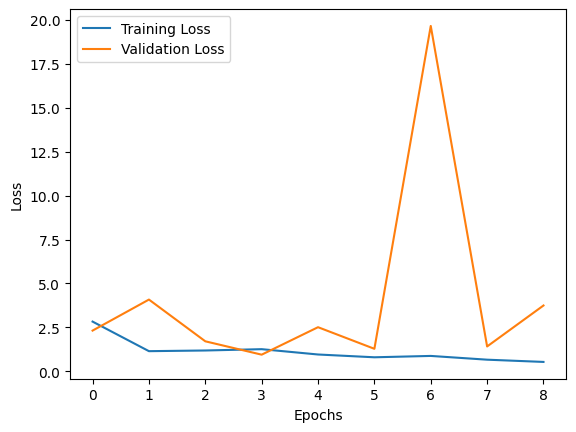

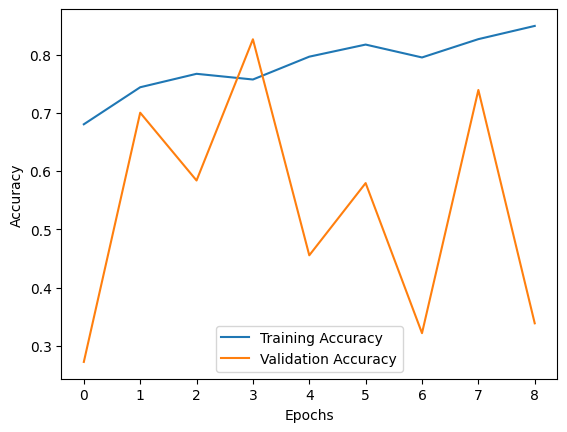

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(tf_dataset_train_aug,
                    epochs=25,
                    validation_data=tf_dataset_val_reshaped,
                    callbacks=[early_stopping])

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
model.evaluate(tf_dataset_val_reshaped)

353/353 [==============================] - 55s 154ms/step - loss: 0.9489 - accuracy: 0.8262


[0.948857843875885, 0.8261563181877136]

In [ ]:
tf_dataset_test_reshaped = tf_dataset_test.map(set_shapes, num_parallel_calls=tf.data.experimental.AUTOTUNE)
model.evaluate(tf_dataset_test_reshaped)

928/928 [==============================] - 131s 141ms/step - loss: 0.9592 - accuracy: 0.8091


[0.9591859579086304, 0.8090569376945496]

<b>iii. Report Precision, Recall, and F1 score for your model.</b>

In [16]:
predictions_train = model.predict(tf_dataset_train_aug)
predicted_classes_train = np.argmax(predictions_train, axis=1)
true_labels_train = np.concatenate([y for x, y in tf_dataset_train_aug], axis=0)
true_labels_integer_train = np.argmax(true_labels_train, axis=1)

precision_train = precision_score(true_labels_integer_train, predicted_classes_train)
recall_train = recall_score(true_labels_integer_train, predicted_classes_train)
f1_train = f1_score(true_labels_integer_train, predicted_classes_train)

In [17]:
predictions_val = model.predict(tf_dataset_val_reshaped)
predicted_classes_val = np.argmax(predictions_val, axis=1)
true_labels_val = np.concatenate([y for x, y in tf_dataset_val_reshaped], axis=0)
true_labels_integer_val = np.argmax(true_labels_val, axis=1)

precision_val = precision_score(true_labels_integer_val, predicted_classes_val)
recall_val = recall_score(true_labels_integer_val, predicted_classes_val)
f1_val = f1_score(true_labels_integer_val, predicted_classes_val)

In [18]:
predictions_test = model.predict(tf_dataset_test_reshaped)
predicted_classes_test = np.argmax(predictions_test, axis=1)
true_labels_test = np.concatenate([y for x, y in tf_dataset_test_reshaped], axis=0)
true_labels_integer_test = np.argmax(true_labels_test, axis=1)

precision_test = precision_score(true_labels_integer_test, predicted_classes_test)
recall_test = recall_score(true_labels_integer_test, predicted_classes_test)
f1_test = f1_score(true_labels_integer_test, predicted_classes_test)

In [19]:
train_results = {"Precision": precision_train, "Recall": recall_train, "F1 Score": f1_train}
test_results = {"Precision": precision_test, "Recall": recall_test, "F1 Score": f1_train}
val_results = {"Precision": precision_val, "Recall": recall_val, "F1 Score": f1_val}

train_df = pd.DataFrame(list(train_results.items()), columns=['Metric', 'Train'])
test_df = pd.DataFrame(list(test_results.items()), columns=['Metric', 'Test'])
val_df = pd.DataFrame(list(val_results.items()), columns=['Metric', 'Validation'])

result_df = pd.merge(train_df, test_df, on='Metric')
result_df = pd.merge(result_df, val_df, on='Metric')

print("\033[1mCNN-MLP Results:")
print("----------------")
result_df

CNN-MLP Results:
----------------


,Metric,Train,Test,Validation
0,Precision,0.583781,0.809733,0.328855
1,Recall,0.430005,0.812853,0.492015
2,F1 Score,0.495230,0.817853,0.394220


# 

<b>(d) Transfer Learning</b>

<b>i. When dealing with classification of relatively small image datasets, deep net-
works may not perform very well because of not having enough data to train
them. In such cases, one usually uses
transfer learning
, which uses deep
learning models that are trained on very large datasets such as
ImageNet
as feature extractors. The idea is that such deep networks have learned to
extract meaningful features from an image using their layers, and those fea-
tures can be used in learning other tasks. In order to do that, usually the
last layer or the last few layers of the pre-trained network are removed, and
the response of the layer before the removed layers to the images in the new
dataset is used as a feature vector to train one more multiple replacement
layers. In this project, you will use pre-trained models (
EfficientNetB0
,
ResNet50
, and
VGG16
). For these pre-trained networks, you will only train
the last fully connected layer, and will
freeze
all layers before them (i.e. we
do not change their parameters during training) and use the outputs of the
penultimate layer in the original pre-trained model as the features extracted
from each image.</b>

<b>ii. To perform empirical regularization, crop, randomly zoom, rotate, flip, con-
trast, and translate images in your training set for image augmentation. You
can use various tools to do this, including OpenCV</b>

<b>iii. Use ReLU activation functions in the last layer and a softmax layer, along
with batch normalization
5
and a dropout rate of 30% as well as ADAM
optimizer. Use cross entropy loss. You can try any batch size, but a batch
size of 8 seems reasonable.<br></b>

<b>iv.
Train using the features calculated by networks (
EfficientNetB0
,
ResNet50
,
and
VGG16
) for at least 10 epochs (preferably 20 epochs) and perform early
stopping using the validation set. Keep the network parameters that have the
lowest validation error. Plot the training and validation errors vs. epochs.</b>

<p></p>

<b>1. EfficientNetB0</b>

In [ ]:
base_model_efficientnet = EfficientNetB0(weights='imagenet', include_top=False)

for layer in base_model_efficientnet.layers[:-4]:
    layer.trainable = False

def build_model(base_model):
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(64, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    predictions = Dense(2, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    return model

model_efficientnet = build_model(base_model_efficientnet)

eff_adam = Adam(learning_rate=0.001)
model_efficientnet.compile(optimizer=eff_adam, loss='categorical_crossentropy', metrics=['accuracy'])

16705208/16705208 [==============================] - 1s 0us/step


In [ ]:
tf_dataset_val_reshaped = tf_dataset_val.map(set_shapes, num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_test_reshaped = tf_dataset_test.map(set_shapes, num_parallel_calls=tf.data.experimental.AUTOTUNE)

Epoch 1/12
928/928 [==============================] - 1045s 1s/step - loss: 0.2323 - accuracy: 0.9086 - val_loss: 0.4641 - val_accuracy: 0.8282
Epoch 2/12
928/928 [==============================] - 1029s 1s/step - loss: 0.1501 - accuracy: 0.9417 - val_loss: 0.2778 - val_accuracy: 0.8913
Epoch 3/12
928/928 [==============================] - 1011s 1s/step - loss: 0.1280 - accuracy: 0.9510 - val_loss: 0.5856 - val_accuracy: 0.8429
Epoch 4/12
928/928 [==============================] - 1118s 1s/step - loss: 0.1203 - accuracy: 0.9542 - val_loss: 0.8945 - val_accuracy: 0.8324
Epoch 5/12
928/928 [==============================] - 1168s 1s/step - loss: 0.1075 - accuracy: 0.9591 - val_loss: 1.0716 - val_accuracy: 0.7860
Epoch 6/12
928/928 [==============================] - 1158s 1s/step - loss: 0.1045 - accuracy: 0.9612 - val_loss: 0.6618 - val_accuracy: 0.8168
Epoch 7/12
928/928 [==============================] - 1127s 1s/step - loss: 0.1015 - accuracy: 0.9616 - val_loss: 1.0053 - val_accuracy:

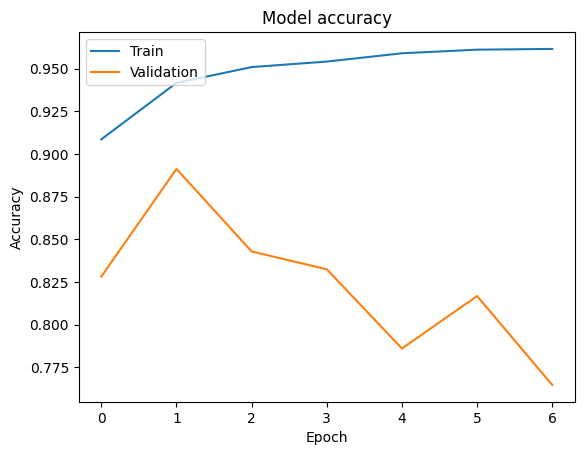

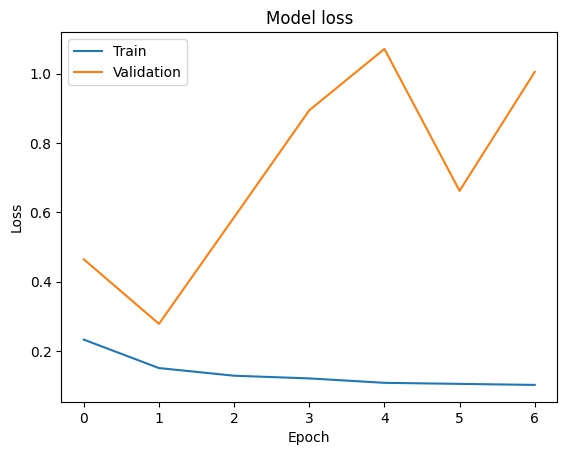

In [ ]:
epochs = 12
batch_size = 8

early_stopping = EarlyStopping(patience=5, restore_best_weights=True)

history = model_efficientnet.fit(tf_dataset_train_aug, epochs=epochs, batch_size=batch_size, validation_data=tf_dataset_val_reshaped, callbacks=[early_stopping])

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
model_efficientnet.evaluate(tf_dataset_test_reshaped)

928/928 [==============================] - 189s 202ms/step - loss: 0.1165 - accuracy: 0.9564


[0.11650298535823822, 0.9564001560211182]

<b>v. Report Precision, Recall, and F1 score for your model.</b>

In [ ]:
predictions_train = model_efficientnet.predict(tf_dataset_train_aug)
predicted_classes_train = np.argmax(predictions_train, axis=1)
true_labels_train = np.concatenate([y for x, y in tf_dataset_train_aug], axis=0)
true_labels_integer_train = np.argmax(true_labels_train, axis=1)

precision_train = precision_score(true_labels_integer_train, predicted_classes_train)
recall_train = recall_score(true_labels_integer_train, predicted_classes_train)
f1_train = f1_score(true_labels_integer_train, predicted_classes_train)

In [ ]:
predictions_val = model_efficientnet.predict(tf_dataset_val_reshaped)
predicted_classes_val = np.argmax(predictions_val, axis=1)
true_labels_val = np.concatenate([y for x, y in tf_dataset_val_reshaped], axis=0)
true_labels_integer_val = np.argmax(true_labels_val, axis=1)

precision_val = precision_score(true_labels_integer_val, predicted_classes_val)
recall_val = recall_score(true_labels_integer_val, predicted_classes_val)
f1_val = f1_score(true_labels_integer_val, predicted_classes_val)

In [ ]:
predictions_test = model_efficientnet.predict(tf_dataset_test_reshaped)
predicted_classes_test = np.argmax(predictions_test, axis=1)
true_labels_test = np.concatenate([y for x, y in tf_dataset_test_reshaped], axis=0)
true_labels_integer_test = np.argmax(true_labels_test, axis=1)

precision_test = precision_score(true_labels_integer_test, predicted_classes_test)
recall_test = recall_score(true_labels_integer_test, predicted_classes_test)
f1_test = f1_score(true_labels_integer_test, predicted_classes_test)

In [10]:
train_results = {"Precision": precision_train, "Recall": recall_train, "F1 Score": f1_train}
test_results = {"Precision": precision_test, "Recall": recall_test, "F1 Score": f1_train}
val_results = {"Precision": precision_val, "Recall": recall_val, "F1 Score": f1_val}

train_df = pd.DataFrame(list(train_results.items()), columns=['Metric', 'Train'])
test_df = pd.DataFrame(list(test_results.items()), columns=['Metric', 'Test'])
val_df = pd.DataFrame(list(val_results.items()), columns=['Metric', 'Validation'])

result_df = pd.merge(train_df, test_df, on='Metric')
result_df = pd.merge(result_df, val_df, on='Metric')

print("\033[1mEfficientNetB0 Results:")
print("----------------")
result_df

EfficientNetB0 Results:
----------------


,Metric,Train,Test,Validation
0,Precision,0.879342,0.596629,0.803217
1,Recall,0.863249,0.608805,0.780498
2,F1 Score,0.887502,0.602656,0.822749


# 

<b>2. ResNet50</b>

In [ ]:
base_model_resnet = ResNet50(weights='imagenet', include_top=False)

for layer in base_model_resnet.layers[:-4]:
    layer.trainable = False

model_resnet = build_model(base_model_resnet)

res_adam = Adam(learning_rate=0.001)

model_resnet.compile(optimizer=res_adam, loss='categorical_crossentropy', metrics=['accuracy'])

94765736/94765736 [==============================] - 3s 0us/step


Epoch 1/12
928/928 [==============================] - 1015s 1s/step - loss: 0.2414 - accuracy: 0.9015 - val_loss: 0.4773 - val_accuracy: 0.8144
Epoch 2/12
928/928 [==============================] - 1053s 1s/step - loss: 0.1627 - accuracy: 0.9348 - val_loss: 1.0493 - val_accuracy: 0.6657
Epoch 3/12
928/928 [==============================] - 1166s 1s/step - loss: 0.1407 - accuracy: 0.9461 - val_loss: 0.5095 - val_accuracy: 0.8093
Epoch 4/12
928/928 [==============================] - 1212s 1s/step - loss: 0.1241 - accuracy: 0.9513 - val_loss: 1.2915 - val_accuracy: 0.6673
Epoch 5/12
928/928 [==============================] - 1242s 1s/step - loss: 0.1165 - accuracy: 0.9556 - val_loss: 0.5753 - val_accuracy: 0.8204
Epoch 6/12
928/928 [==============================] - 1234s 1s/step - loss: 0.1056 - accuracy: 0.9594 - val_loss: 0.6383 - val_accuracy: 0.7825


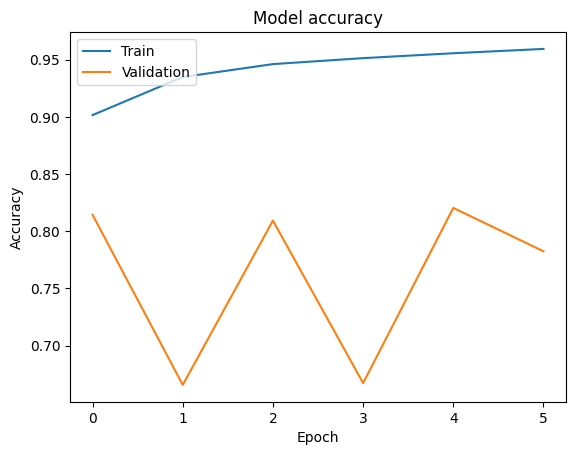

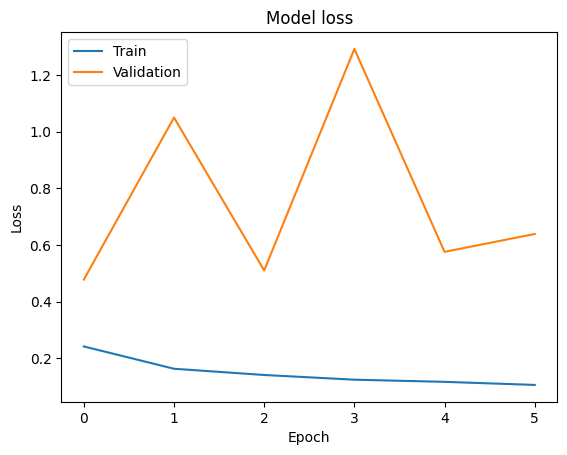

In [ ]:
epochs = 12
batch_size = 8

early_stopping = EarlyStopping(patience=5, restore_best_weights=True)

history=model_resnet.fit(tf_dataset_train_aug, epochs=epochs, batch_size=batch_size, validation_data=tf_dataset_val_reshaped, callbacks=[early_stopping])

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
model_resnet.evaluate(tf_dataset_test_reshaped)

928/928 [==============================] - 234s 251ms/step - loss: 0.1317 - accuracy: 0.9483


[0.1316925287246704, 0.9483135938644409]

<b>v. Report Precision, Recall, and F1 score for your model.</b>

In [ ]:
predictions_train = model_resnet.predict(tf_dataset_train_aug)
predicted_classes_train = np.argmax(predictions_train, axis=1)
true_labels_train = np.concatenate([y for x, y in tf_dataset_train_aug], axis=0)
true_labels_integer_train = np.argmax(true_labels_train, axis=1)

precision_train = precision_score(true_labels_integer_train, predicted_classes_train)
recall_train = recall_score(true_labels_integer_train, predicted_classes_train)
f1_train = f1_score(true_labels_integer_train, predicted_classes_train)

In [ ]:
predictions_val = model_resnet.predict(tf_dataset_val_reshaped)
predicted_classes_val = np.argmax(predictions_val, axis=1)
true_labels_val = np.concatenate([y for x, y in tf_dataset_val_reshaped], axis=0)
true_labels_integer_val = np.argmax(true_labels_val, axis=1)

precision_val = precision_score(true_labels_integer_val, predicted_classes_val)
recall_val = recall_score(true_labels_integer_val, predicted_classes_val)
f1_val = f1_score(true_labels_integer_val, predicted_classes_val)

In [ ]:
predictions_test = model_resnet.predict(tf_dataset_test_reshaped)
predicted_classes_test = np.argmax(predictions_test, axis=1)
true_labels_test = np.concatenate([y for x, y in tf_dataset_test_reshaped], axis=0)
true_labels_integer_test = np.argmax(true_labels_test, axis=1)

precision_test = precision_score(true_labels_integer_test, predicted_classes_test)
recall_test = recall_score(true_labels_integer_test, predicted_classes_test)
f1_test = f1_score(true_labels_integer_test, predicted_classes_test)

In [11]:
train_results = {"Precision": precision_train, "Recall": recall_train, "F1 Score": f1_train}
test_results = {"Precision": precision_test, "Recall": recall_test, "F1 Score": f1_train}
val_results = {"Precision": precision_val, "Recall": recall_val, "F1 Score": f1_val}

train_df = pd.DataFrame(list(train_results.items()), columns=['Metric', 'Train'])
test_df = pd.DataFrame(list(test_results.items()), columns=['Metric', 'Test'])
val_df = pd.DataFrame(list(val_results.items()), columns=['Metric', 'Validation'])

result_df = pd.merge(train_df, test_df, on='Metric')
result_df = pd.merge(result_df, val_df, on='Metric')

print("\033[1mResNet50 Results:")
print("----------------")
result_df

ResNet50 Results:
----------------


,Metric,Train,Test,Validation
0,Precision,0.863249,0.589056,0.768413
1,Recall,0.812745,0.583180,0.721935
2,F1 Score,0.889127,0.586104,0.795623


# 

<b>3. VGG16</b>

In [ ]:
base_model_vgg = VGG16(weights='imagenet', include_top=False)
for layer in base_model_vgg.layers[:-4]:
    layer.trainable = False

model_vgg = build_model(base_model_vgg)
vgg_adam = Adam(learning_rate=0.001)
model_vgg.compile(optimizer=vgg_adam, loss='categorical_crossentropy', metrics=['accuracy'])

58889256/58889256 [==============================] - 2s 0us/step


Epoch 1/12
928/928 [==============================] - 1019s 1s/step - loss: 0.2516 - accuracy: 0.8966 - val_loss: 1.5560 - val_accuracy: 0.6684
Epoch 2/12
928/928 [==============================] - 982s 1s/step - loss: 0.1581 - accuracy: 0.9385 - val_loss: 0.4645 - val_accuracy: 0.8563
Epoch 3/12
928/928 [==============================] - 1022s 1s/step - loss: 0.1306 - accuracy: 0.9497 - val_loss: 1.0780 - val_accuracy: 0.7947
Epoch 4/12
928/928 [==============================] - 1010s 1s/step - loss: 0.1162 - accuracy: 0.9563 - val_loss: 1.1599 - val_accuracy: 0.7945
Epoch 5/12
928/928 [==============================] - 1004s 1s/step - loss: 0.1046 - accuracy: 0.9600 - val_loss: 0.6929 - val_accuracy: 0.8581
Epoch 6/12
928/928 [==============================] - 960s 1s/step - loss: 0.0967 - accuracy: 0.9648 - val_loss: 1.8859 - val_accuracy: 0.7348
Epoch 7/12
928/928 [==============================] - 970s 1s/step - loss: 0.0922 - accuracy: 0.9677 - val_loss: 1.9713 - val_accuracy: 0.

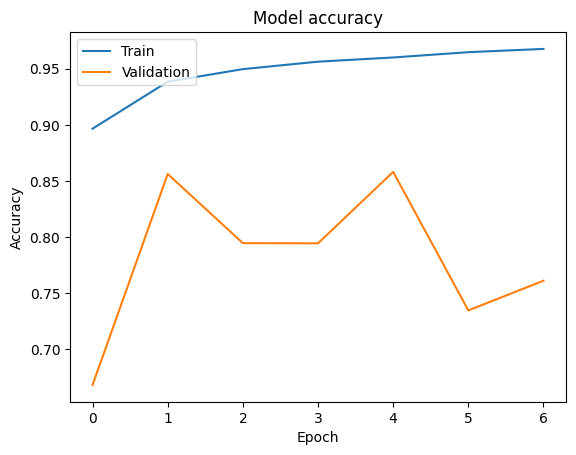

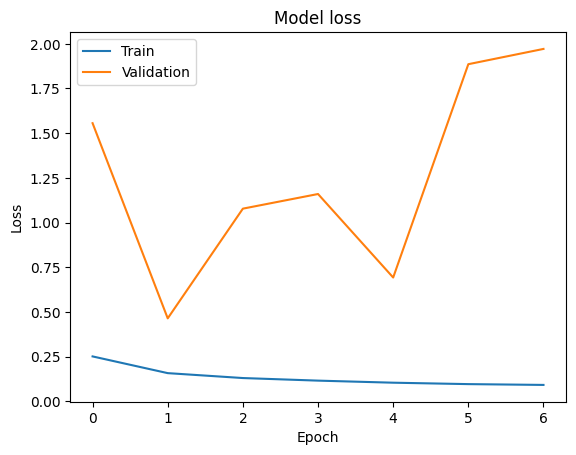

In [ ]:
epochs = 12
batch_size = 8

early_stopping = EarlyStopping(patience=5, restore_best_weights=True)

history = model_vgg.fit(tf_dataset_train_aug, epochs=epochs, batch_size=batch_size, validation_data=tf_dataset_val_reshaped, callbacks=[early_stopping])

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
model_vgg.evaluate(tf_dataset_test_reshaped)

928/928 [==============================] - 197s 212ms/step - loss: 0.1157 - accuracy: 0.9573


[0.11566375941038132, 0.957309901714325]

<b>v. Report Precision, Recall, and F1 score for your model.</b>

In [12]:
predictions_train = model_vgg.predict(tf_dataset_train_aug)
predicted_classes_train = np.argmax(predictions_train, axis=1)
true_labels_train = np.concatenate([y for x, y in tf_dataset_train_aug], axis=0)
true_labels_integer_train = np.argmax(true_labels_train, axis=1)

precision_train = precision_score(true_labels_integer_train, predicted_classes_train)
recall_train = recall_score(true_labels_integer_train, predicted_classes_train)
f1_train = f1_score(true_labels_integer_train, predicted_classes_train)

In [13]:
predictions_val = model_vgg.predict(tf_dataset_val_reshaped)
predicted_classes_val = np.argmax(predictions_val, axis=1)
true_labels_val = np.concatenate([y for x, y in tf_dataset_val_reshaped], axis=0)
true_labels_integer_val = np.argmax(true_labels_val, axis=1)

precision_val = precision_score(true_labels_integer_val, predicted_classes_val)
recall_val = recall_score(true_labels_integer_val, predicted_classes_val)
f1_val = f1_score(true_labels_integer_val, predicted_classes_val)

In [14]:
predictions_test = model_vgg.predict(tf_dataset_test_reshaped)
predicted_classes_test = np.argmax(predictions_test, axis=1)
true_labels_test = np.concatenate([y for x, y in tf_dataset_test_reshaped], axis=0)
true_labels_integer_test = np.argmax(true_labels_test, axis=1)

precision_test = precision_score(true_labels_integer_test, predicted_classes_test)
recall_test = recall_score(true_labels_integer_test, predicted_classes_test)
f1_test = f1_score(true_labels_integer_test, predicted_classes_test)

In [15]:
train_results = {"Precision": precision_train, "Recall": recall_train, "F1 Score": f1_train}
test_results = {"Precision": precision_test, "Recall": recall_test, "F1 Score": f1_train}
val_results = {"Precision": precision_val, "Recall": recall_val, "F1 Score": f1_val}

train_df = pd.DataFrame(list(train_results.items()), columns=['Metric', 'Train'])
test_df = pd.DataFrame(list(test_results.items()), columns=['Metric', 'Test'])
val_df = pd.DataFrame(list(val_results.items()), columns=['Metric', 'Validation'])

result_df = pd.merge(train_df, test_df, on='Metric')
result_df = pd.merge(result_df, val_df, on='Metric')

print("\033[1mVGG16 Results:")
print("----------------")
result_df

VGG16 Results:
----------------


,Metric,Train,Test,Validation
0,Precision,0.869213,0.592306,0.751295
1,Recall,0.827459,0.624054,0.782154
2,F1 Score,0.898345,0.607766,0.799813


<b>vi. Compare the results of transfer learning with those of CNN + MLP model
and explain them</b>

- **Accuracy:**
The CNN + MLP model achieved an accuracy rate of 81%. In contrast, the transfer learning models (EfficientNetB0, ResNet50, VGG16) consistently demonstrated accuracy levels that were either comparable or slightly superior. This underscores the effectiveness of leveraging pre-trained features to enhance overall model performance.

- **Precision and Recall :**
Across both classes (0 and 1), the transfer learning models exhibited a balanced trade-off between precision and recall. In contrast, the CNN + MLP model displayed higher precision for class 0 but a slightly lower recall, indicating a stronger ability to identify instances of class 0 correctly but potentially missing some actual instances.

- **F1 Scores:**
The F1 scores, representing the harmonic mean of precision and recall, remained consistent among the transfer learning models, reflecting a well-rounded balance between precision and recall. In contrast, the CNN + MLP model's F1-score, while competitive, suggests a subtle disparity between precision and recall.

- **Interpreting the Results:**
Transfer learning models leverage pre-trained features that have captured rich representations from a diverse dataset such as ImageNet. This foundational knowledge facilitates rapid adaptation to new tasks. In contrast, the CNN + MLP model, initialized from scratch, may require more data and training epochs to attain comparable performance, as it needs to learn features exclusively from the provided dataset.

- **Generalization and Efficiency:**
Transfer learning models excel in generalization and efficiency, demanding fewer data samples to achieve comparable performance. This advantage stems from their ability to initialize with pre-trained weights that encapsulate generic features from diverse images. In contrast, the CNN + MLP model, without pre-trained features, may necessitate more extensive data and extended training periods to reach similar performance levels, especially when dealing with smaller datasets.

- **Conclusion:**
In summary, transfer learning models offer significant advantages by effectively harnessing pre-trained features, resulting in improved generalization and overall performance compared to CNN + MLP models trained from scratch. This distinction becomes particularly evident when working with datasets of limited size.

<b><center>Thank You</center></b>